Importing necessary packages

In [1]:
from textblob import TextBlob
import nltk

import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import numpy as np
from math import ceil
import re

import emoji

![CelsiusBanner](images/celsius.png)

<p style="text-align: center;">Celsius Network, founded in 2017, goes by the hashtag #UnBankYourself.
    You can check out their website: <a href = 'https://celsius.network/'>Celsius Network</a></p>

## DATA EXTRACTION

Let's start with Data Extraction. We'll be retrieving data from Celsius' Community Chat on Telegram. For this, we'll use [Telethon](https://github.com/LonamiWebs/Telethon)

What is Telethon?

> "Telethon is an asyncio Python 3 MTProto library to interact with Telegram's API as a user or through a bot account."

We are basically going to use it as a means for data extraction. 
The data will be extracted into a JSON file which we'll load via Pandas into a DataFrame

There are several other use cases for Telethon, check it out on [Telethon-Github](https://github.com/LonamiWebs/Telethon)

### THE DATASET

The dataset used for the project contains about 70,000 messages, but since we're planning on doing a three month analysis we'll be filtering out the dataset. Preprocessing includes removing emojis, links, @user_tags, any sorts of punctuations, then dropping NaN values from the dataset.

In [2]:
test = pd.read_json('training data/testbig.json', lines=True)
test = test.reset_index(drop=True)
mask = [isinstance(item, (str, bytes)) for item in test['message']]
test = test.loc[mask]

Our dataset includes two columns, one for messages, the other for time (more precisely, the time when the message arrived)

In [3]:
#PRE-PROCESSING

In [4]:
def strip_emoji(text):
    #Removing Emojis
    text = re.sub(emoji.get_emoji_regexp(), '', text)
    #Removing links
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', text)
    #Removing user @ tags
    text = re.sub("(@[A-Za-z0-9_]+)","", text)
    
    return text

test['message'] = test['message'].apply(strip_emoji)

In [5]:
def remove_punctuation(ax): 
  
    # punctuation marks 
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~''' 
    for x in ax.lower(): 
        if x in punctuations: 
            ax = ax.replace(x, "") 
    return ax

test['message'] = test['message'].apply(remove_punctuation)

In [6]:
test.dropna(inplace=True)
test = test.reset_index(drop=True)

## SENTIMENT ANALYSIS



![Sentiments](images/banner3.png)

We all know what sentiment analysis is, for those who don't, it's a technique of using NLP based algorithms to analyse texts and assign them some label (for example, positive or negative). 
Like user reviews can be rated good or bad based on the content of the review.
Businesses today are heavily dependent on data.
Sentiment Analysis provides an efficient way to determine the next steps or series of decisions,  a company should take to resolve issues(if sentiment score is overall negative)

That being said, we're going to perform a sentiment analysis on a set of messages from a Telegram chat of Celsius Community. 
There are a lot of challenges when it comes to sentiment analysis, say sarcasm or correct interpretation of words, correctly understanding emotions through text is always a hit and miss. Often, users write texts that actually mean well but the algorithm rules it out to be negative based on some set or words. 

> "I liked the story behind the game but not much of the gameplay experience"

The above sentiment could be categorized under either positive or negative since it contains multiple polarities.

![Sarcasm?](images/03.jpg)

So the label alloted to the text may not be as accurate as one would imagine it. To improve the accuracy one can use labeled dataset to train a model and further using that model to predict a test dataset.

Since we do not have a labeled dataset, we'll be using some means of unsupervised learning to predict sentiment on the messages. There are two well known packages out there for NLP tasks, namely TextBlob and VADER-nltk.

## TEXT BLOB

TextBlob is a Natural Language Processing (aka NLP) processing library that contains a rule-based sentiment analsysis library, which we're going to use below. 

The other is Valence Aware Dictionary and sEntiment Reasoner (aka VADER), a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

We're going to be using TextBlob's sentiment analysis library to categorize our data into three parts, positive | neutral | negative. 

the .sentiment method returns a tuple which contains, polarity and subjectivity.
While polarity is a float within range of -1 to +1, subjectivity ranges from 0 to +1.
Negative polarity would mean a negative sentiment, where a positive value would be a positive sentiment, leaving 0 as neutral.
Subjectivity value would be a rating of how subjective the text is, value closer to 0 is objective or factual, value closer to 1 would mean the text is subjective to a particular user.

In [7]:
review=[]
score = []
for x in test['message']:
    review.append(TextBlob(x).sentiment.polarity)
    score.append(TextBlob(x).sentiment.polarity)

In [8]:
reviews = []
for x in review:
    if x>0.1:
        reviews.append("Positive")
    elif x<0:
        reviews.append("Negative")
    else:
        reviews.append("Neutral")

In [9]:
test['sentiment']=reviews
test['score'] = score

In [10]:
#Since our dataset includes message's date in UNIX time, we need to convert it to human readable format

In [11]:
test['time'] = pd.to_datetime(test['time'], unit='ms')
test['Date'] = test['time'].dt.normalize()
test['Time'] = test['time'].dt.hour + test['time'].dt.minute/60

In [12]:
test = test[(test['time'].dt.month != 10)]
test = test[(test['time'].dt.month != 2)]

Now, we need to assign Week numbers according to the Month. We're not assigning weeks based on 7 day period, we're assigning them on the the fact that Week starts at Sunday.

In [13]:
def week_of_month(dt):
    
    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return str(dt.year)+ '-' + str(dt.month) + ' ' + "(Week: {})".format(str(ceil(adjusted_dom/7.0)))

In [14]:
test['Week'] = test['Date'].apply(week_of_month)

In [15]:
test['message'].replace('', np.nan, inplace=True)
test.dropna(subset=['message'], inplace=True)
test = test.reset_index(drop=True)

In [16]:
text123 = " ".join(review for review in test.message)

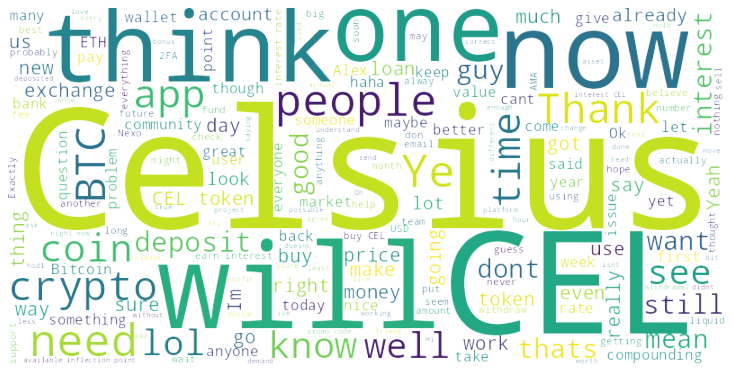

In [17]:
wordcloud = WordCloud(width=800, height=400, background_color="rgba(255, 255, 255, 0)", mode="RGBA").generate(text123)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Let's see how the messages are labeled by TextBlob

In [18]:
colors3 = ['#FEC9C9','#99AFCC','#799FCB']
colors2 = ['#FEC9C9', '#799FCB']

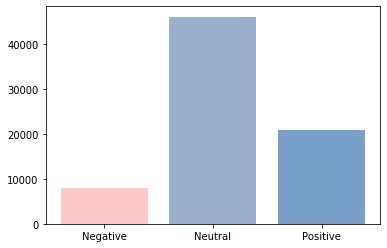

In [19]:
keys, counts = np.unique(reviews, return_counts=True)
plt.bar(keys, counts, color=colors3)
plt.show()

Looking at the graph we can say that it did a decent job at labeling the messages, although the accuracy is still not very good but it can be said that for a chat neutral sentiments were predicted properly. Observing the messages and sentiments, we can see that TextBlob doesn't label all the 'Truly' negative messages as negative and but overall it does a good job of providing us a basic idea of overall sentiment of the chat.

We can plot a pie chart splitting data into categories of 'Positive, Neutral & Negative', getting stats of about 62% as neutral, 28% as Positive and 11% as Negative. Specifically if we look into just Positive and Negative parts, we get around 73% and 27% respectively.

In [20]:
count_posneg = np.array([counts[0], counts[2]])
key_posneg = np.array(['Negative', 'Positive'])

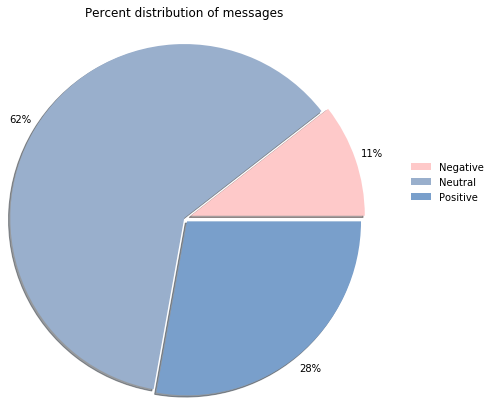

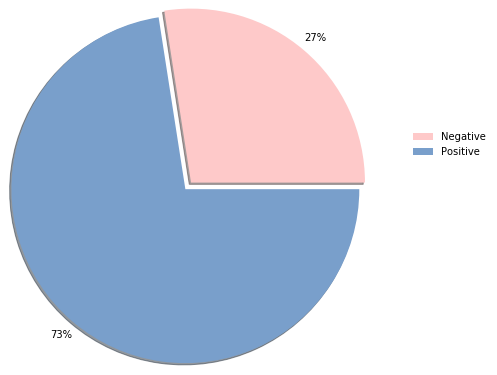

In [21]:

fig, ax = plt.subplots()
explode = (0.08, 0, 0.05)
ax.pie(counts, explode=explode, autopct='%1.0f%%', shadow=True, pctdistance=1.1, radius=2, colors = colors3)
ax.legend(labels=keys, frameon=False, bbox_to_anchor=(1.5, 0.8))
plt.title("Percent distribution of messages", y=1.4, x=0.5)
fig1, ax1 = plt.subplots()
explode = (0.08, 0.02)
ax1.pie(count_posneg, explode=explode, autopct='%1.0f%%', shadow=True, pctdistance=1.1, radius=2, colors = colors2)
ax1.legend(labels=key_posneg, frameon=False, bbox_to_anchor=(1.5, 0.8))
plt.show()


Now, Celsius is a wonderful budding cryptocurrency that has some amazing people working for it and we did basically extract tons of data off their community chat, so it makes sense to find out what the analysis says about them.

How about we create a filter that pours out only those messages that are related to Celsius or it's community? Let's setup some keywords that are relatable to Celsius(CEL) and only return those messages which has one of the word from our list of keywords.

In [22]:
keywords = ['cel', 'CEL', 'celsius', 'CELSIUS', 'Celsius', 'Cel', 'Celsians', 'CELSIANS', 'celsians', 'celcius','CELCIUS','Celcius']

In [23]:
t_pos = test['sentiment'].value_counts()[1]
t_neg = test['sentiment'].value_counts()[2]

In [24]:
def find_word(text, s1=keywords):
    matches = []
    for x in text['message']:
        tokens = nltk.word_tokenize(x)
        for word in tokens:
            if word in s1:
                matches.append(x)
                break
    return matches

found_cel = find_word(test)

In [25]:
test_cel = test.copy()
test_cel['message'] = test_cel.loc[test_cel['message'].isin(found_cel)]

In [26]:
test_cel = test_cel.dropna()

Let's plot a pie chart again, but now for the CEL_filtered dataset!

In [27]:
count_celpos = np.array([test_cel['sentiment'].value_counts()[1], t_pos])
key_celpos = np.array(['Comments about CEL/Celsians/Celsius', 'Total Positive'])

count_celneg = np.array([test_cel['sentiment'].value_counts()[2], t_neg])
key_celneg = np.array(['Comments about CEL/Celsians/Celsius', 'Total Negative'])

In [28]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format

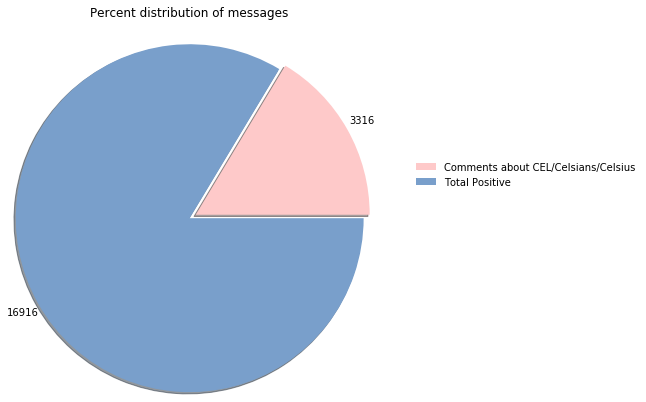

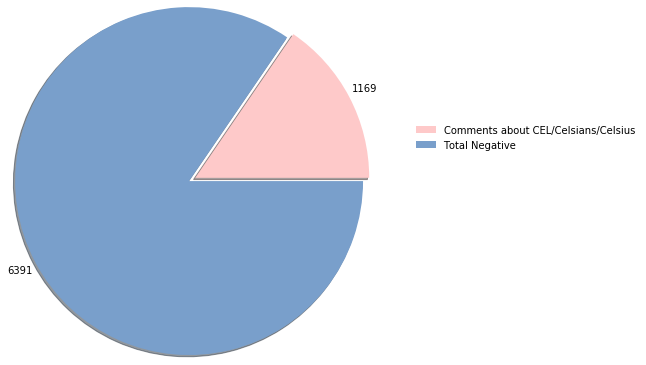

In [29]:
fig, ax = plt.subplots()
explode = (0.08, 0)
ax.pie(count_celpos, explode=explode, autopct=autopct_format(count_celpos), shadow=True, pctdistance=1.1, radius=2, colors = colors2)
ax.legend(labels=key_celpos, frameon=False, bbox_to_anchor=(1.5, 0.8))
plt.title("Percent distribution of messages", y=1.4, x=0.5)
fig1, ax1 = plt.subplots()
explode = (0.08, 0)
ax1.pie(count_celneg, explode=explode, autopct=autopct_format(count_celneg), shadow=True, pctdistance=1.1, radius=2, colors = colors2)
ax1.legend(labels=key_celneg, frameon=False, bbox_to_anchor=(1.5, 0.8))
plt.show()


![Analyze data](images/01.jpg)

The data above doesn't look too shabby, eh? But we do need to go dig deeper.
Let's take price into perspective and broaden our analysis.
The dataset below is acquired from [CoinGecko's beautiful API](https://www.coingecko.com/en/api#explore-api)

The dataset here is in JSON format which is easy to read via Pandas' read_json.
The dataset cotains four columns; time, price, total_volumes, market_caps. We would be focusing on the price change here so let's drop the last two columns.
The price is the !closing? price of the day and since we have extra data for October and February, we should drop those values since our test dataset for the chat is confined for three months from November-2019 to January-2020.

In [30]:
pricem = pd.read_json('training data/celdatabig.json')

In [31]:
del pricem['total_volumes']
del pricem['market_caps']

In [32]:
pricem = pd.DataFrame(pricem.prices.tolist(), columns=['time', 'price'])

Let's convert the time from UNIX format to datetime and extract the necessary data from it, the same way we did for our Chat_set. After extraction, we don't need the datetime format anymore. So what we're going to do is take out the Week as a category and take average of the prices belonging to that Week.
For eg, for Week X we will take average of seven days' prices.

In [33]:
pricem['time'] = pd.to_datetime(pricem['time'], unit='ms')
pricem['Date'] = pricem['time'].dt.normalize()
pricem = pricem[(pricem['time'].dt.month != 10)]
pricem = pricem[(pricem['time'].dt.month != 2)]

In [34]:
pricem['Week'] = pricem['Date'].apply(week_of_month)

In [35]:
pricem = pricem.groupby('Week', as_index=False)['price'].mean()

In [36]:
pricem

,Week,price
0,2019-11 (Week: 1),0.049935
1,2019-11 (Week: 2),0.048437
2,2019-11 (Week: 3),0.048434
3,2019-11 (Week: 4),0.041898
4,2019-11 (Week: 5),0.045654
5,2019-12 (Week: 1),0.067135
6,2019-12 (Week: 2),0.076959
7,2019-12 (Week: 3),0.071370
8,2019-12 (Week: 4),0.075050
9,2019-12 (Week: 5),0.116218


Let's make a copy of the chat_test dataset and filter it for positive and negative reviews, since neutral doesn't bring anything to the table for monitoring.
We'll make a copy of the dataset filtered for Celsius and do the same, remove neutral sentiment.

In [37]:
test2 = test.copy()
test_cel2 = test_cel.copy()

In [38]:
#Removing all the neutral sentiments off the charts
test_cel2 = test_cel2[test_cel2['sentiment']!='Neutral']
test2 = test2[test2['sentiment']!='Neutral']

Further preprocessing for the charts include grouping the sentiments based on the Week and creating a sentiment score(in %). 
The sentiment score determines how positive the chat was on a particular week. We do this in order to determine if the chat has any relation to the change in prices of CEL. 
For a fairly positive sentiment score to drop down after a decline in price would mean that not many people are happy about it. While a stable score even on a price decline can mean that people have positive hopes and trust for the crypto.

In [39]:
count_dz = test2.groupby(['Week', 'sentiment']).size().reset_index(name='count')
count_dc = test_cel2.groupby(['Week', 'sentiment']).size().reset_index(name='count')

In [40]:
count_dz = count_dz.groupby(['Week', 'sentiment']).agg({'count':'sum'})
count0 = count_dz.groupby(['Week']).agg({'count':'sum'})
count_dz = count_dz.div(count0, level='Week') * 100

count_dc = count_dc.groupby(['Week', 'sentiment']).agg({'count':'sum'})
count1 = count_dc.groupby(['Week']).agg({'count':'sum'})
count_dc = count_dc.div(count1, level='Week') * 100

In [41]:
count_dz = count_dz.reset_index()
count_dz = count_dz[count_dz['sentiment']=='Positive']

count_dc = count_dc.reset_index()
count_dc = count_dc[count_dc['sentiment']=='Positive']

In [42]:
def split_month(txt):
    x = re.search(r"(\d+-\d+)", txt)
    return x.group()

In [43]:
count_dz['Month'] = count_dz['Week'].apply(split_month)
count_dc['Month'] = count_dc['Week'].apply(split_month)

Now let's plot the chart. Here we will be using the beautiful seaborns package along with matplotlib for support. The chart consists of two parts, first graph depicts the sentiment score for every week, the second is the average price per week vs Week (reframe sentence)

We'll be using barplot for the first and lineplot for the other and overlap them by using twinx() since Week on x axis is same for both graphs.

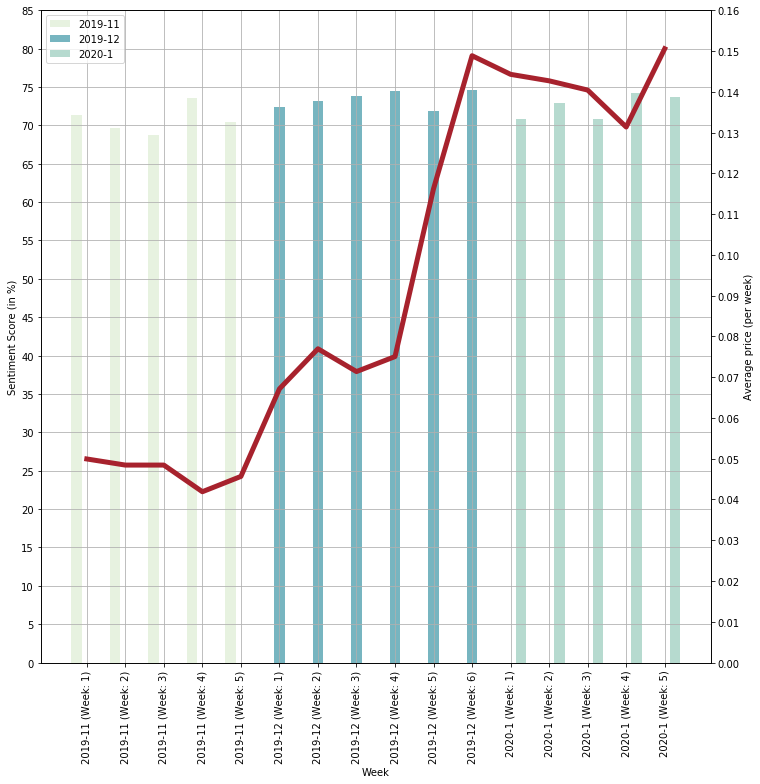

In [44]:
colorsl = ['#e6f5dd', '#6bbdcc', '#b0e0d1']
fig3,ax3 = plt.subplots(figsize=(12,12))
sns.barplot('Week', 'count', 'Month', data=count_dz, palette=colorsl, ax=ax3).set(yticks=np.arange(0,90,5))
ax3.set(ylabel='Sentiment Score (in %)')
ax3.legend(loc=2)
ax3.grid(True)
ax4 = ax3.twinx()
sns.lineplot('Week', 'price', data=pricem, lw=5, color='#A7222D', ax=ax4).set(yticks=np.arange(0,0.17,0.01))
ax4.set(ylabel='Average price (per week)')
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=90)
plt.show()

Doing the same for Celsius filtered dataset

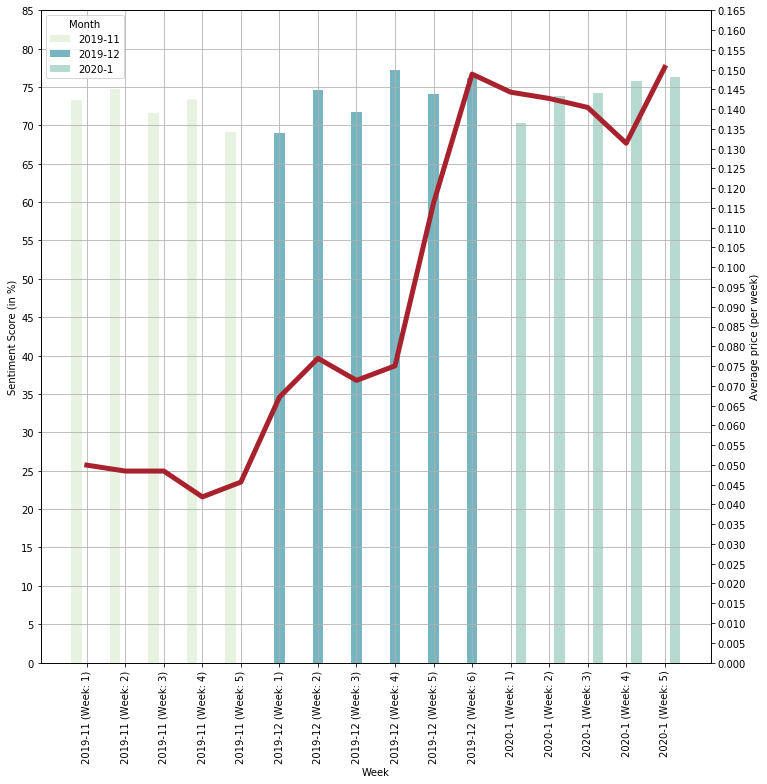

In [45]:
fig3,ax3 = plt.subplots(figsize=(12,12))
sns.barplot('Week', 'count', 'Month', data=count_dc, palette=colorsl, ax=ax3).set(yticks=np.arange(0,90,5))
ax3.set(ylabel='Sentiment Score (in %)')
ax3.grid(True)
ax4 = ax3.twinx()
sns.lineplot('Week', 'price', data=pricem, lw=5, color='#A7222D', ax=ax4).set(yticks=np.arange(0,0.17,0.005))
ax4.set(ylabel='Average price (per week)')
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=90)
plt.show()

From the charts we can conclude a few things, firstly about 70% population of the group are always positive about either Celsius or in general and, about the same are helpful or involve in a positive conversation which can be seen from the positive tags on messages.

Also, near the end of December the chat maintained a positive sentiment of about 72-74% and that's when prices of CEL observed an incline as well.
The overall impact of the chat on CEL cannot be determined due to the fact that our data is from a chat and we used an unsupervised model to predict sentiment. Although it looks pretty well that the community chat's overall quality is pretty positive, kudos to the team!

There are cases where TextBlob incorrectly labels sentiments, some cases have been assigned positive which should have been neutral.

Zooming into the charts into individual week's analysis would help reveal the specific week's overall mood in the chat and oversee the kind of people it's attracting. An incline in negative sentiment would imply that people are not happy about something related to either CEL or generally crypto.

There's still a long way to go with sentiment analysis granted it's failure for sarcasm detection and exact meaning behind the text, but the accuracy can be further improved by introducing a supervised model such as Bayesian Classification, SVD or something else. For these supervised models one would need labeled data to train upon for prediction of sentiments.

![MORE DATA](images/02.png)